In [46]:
root = 'C:/Users/adrso/dev/4TN4/project'

import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms

%matplotlib inline

# Create Dataset

In [47]:
data_dir = f'{root}/data/processed'
batch_size = 32

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), # convert 1 to 3 channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Train dataset and dataloader
dataset = datasets.ImageFolder(f'{data_dir}/train', transform=transform)

print(len(dataset))
train_size = int(len(dataset)*0.69)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_sizes = len(train_dataset)
class_names = dataset.classes

# # Validation dataset and dataloader
# val_dataset = datasets.ImageFolder(f'{data_dir}/val', transform)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

val_sizes = len(val_dataset)

8305


In [48]:
class_names

['fall', 'not_fall']

In [49]:
train_sizes, val_sizes

(5730, 2575)

# Create Model

In [50]:
class FDNet(nn.Module):
    def __init__(self, out_features=2):
        super(FDNet, self).__init__()
        mnet = models.mobilenet_v2(pretrained=True)
        for name, param in mnet.named_parameters():
            if("bn" not in name):
                param.requires_grad_(False)

        # Parameters of newly constructed modules have requires_grad=True by default
        in_features = mnet.classifier[1].in_features
        mnet.classifier = nn.Sequential(
                                nn.Dropout(p=0.2, inplace=False),
                                nn.Linear(in_features,500),
                                nn.ReLU(),
                                nn.Dropout(),
                                nn.Linear(500, out_features))
        self.mnet = mnet

    def forward(self, images):
        features = self.mnet(images)
        return features

## FDNet

In [51]:
# Initialize the model.
model = FDNet()

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FDNet(
  (mnet): MobileNetV2(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1

# Train Model

In [52]:
def train(model, optimizer, loss_fn, train_loader, val_loader, start_epoch = 0, epochs=20, device="cpu"):
    model.to(device)
    for epoch in range(start_epoch, start_epoch+epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)

        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [56]:
# Get class weights
from collections import Counter
sum_dict = dict(Counter(dataset.targets))
sum = sum_dict[0] + sum_dict[1]

class_weights = torch.tensor([10.0, 1.0])
criterion = nn.CrossEntropyLoss(weight=class_weights)


print(class_weights)

tensor([10.,  1.])


In [57]:
# Initialize the model.
model = FDNet()

# Define the optimizer.
params = model.mnet.classifier.parameters()
optimizer = optim.SGD(params, lr=0.001, momentum=0.9)

epochs = 20

In [58]:
%%time
train(model, optimizer, criterion, train_dataloader, val_dataloader, epochs=epochs, device=device)

Epoch: 0, Training Loss: 0.53, Validation Loss: 0.37, accuracy = 0.75
Epoch: 1, Training Loss: 0.38, Validation Loss: 0.29, accuracy = 0.92
Epoch: 2, Training Loss: 0.33, Validation Loss: 0.26, accuracy = 0.93
Epoch: 3, Training Loss: 0.29, Validation Loss: 0.25, accuracy = 0.94
Epoch: 4, Training Loss: 0.26, Validation Loss: 0.21, accuracy = 0.89
Epoch: 5, Training Loss: 0.27, Validation Loss: 0.21, accuracy = 0.94
Epoch: 6, Training Loss: 0.25, Validation Loss: 0.19, accuracy = 0.93
Epoch: 7, Training Loss: 0.24, Validation Loss: 0.20, accuracy = 0.94
Epoch: 8, Training Loss: 0.25, Validation Loss: 0.17, accuracy = 0.93
Epoch: 9, Training Loss: 0.24, Validation Loss: 0.18, accuracy = 0.92
Epoch: 10, Training Loss: 0.23, Validation Loss: 0.17, accuracy = 0.92
Epoch: 11, Training Loss: 0.21, Validation Loss: 0.17, accuracy = 0.94
Epoch: 12, Training Loss: 0.22, Validation Loss: 0.16, accuracy = 0.94
Epoch: 13, Training Loss: 0.22, Validation Loss: 0.17, accuracy = 0.94
Epoch: 14, Train

In [59]:
os.makedirs(f'{root}/trained_model', exist_ok=True)
PATH = f'{root}/trained_model/fdnet.pt'
torch.save(model.state_dict(), PATH)

### Training Confusion Matrix

In [66]:
outputs_np = np.empty((0), dtype=int)
targets_np = np.empty((0), dtype=int)

model.eval()
num_correct = 0 
num_examples = 0
for batch in train_dataloader:
    inputs, targets = batch
    inputs = inputs.to(device)
    outputs = model(inputs)
    outputs = torch.max(F.softmax(outputs, dim=1), dim=1)[1]
    targets = targets.to(device)
    correct = torch.eq(outputs, targets).view(-1)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
    outputs_np = np.concatenate([outputs_np, outputs.cpu().numpy()], axis=None)
    targets_np = np.concatenate([targets_np, targets.cpu().numpy()], axis=None)

print(f'Accuracy: {num_correct / num_examples:.2f}')
print(num_correct, num_examples)


Accuracy: 0.95
5468 5730


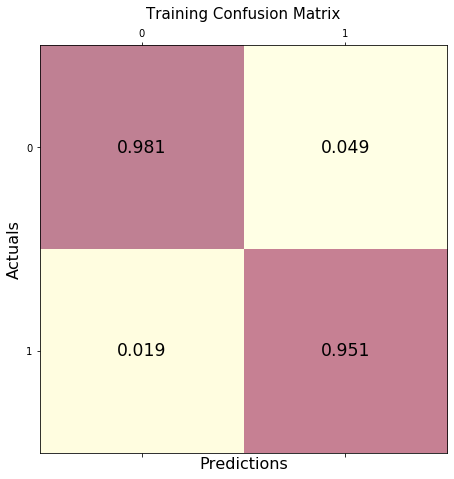

In [67]:

from sklearn import metrics

cmatrix = metrics.confusion_matrix(targets_np, outputs_np, normalize='true')

# Setting the attributes
_, px = plt.subplots(figsize=(7.5, 7.5))
px.matshow(cmatrix, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(cmatrix.shape[0]):
    for n in range(cmatrix.shape[1]):
        px.text(x=m,y=n,s="{:.3f}".format(cmatrix[m, n]), va='center', ha='center', size='xx-large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Training Confusion Matrix', fontsize=15)
plt.show()

# Evaluation

In [60]:
# Test dataset and dataloader
test_dataset = datasets.ImageFolder(f'{data_dir}/test', transform)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

test_sizes = len(test_dataset)

In [61]:
test_sizes

2096

In [62]:
outputs_np = np.empty((0), dtype=int)
targets_np = np.empty((0), dtype=int)

model.eval()
num_correct = 0 
num_examples = 0
for batch in test_dataloader:
    inputs, targets = batch
    inputs = inputs.to(device)
    outputs = model(inputs)
    outputs = torch.max(F.softmax(outputs, dim=1), dim=1)[1]
    targets = targets.to(device)
    correct = torch.eq(outputs, targets).view(-1)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]

    outputs_np = np.concatenate([outputs_np, outputs.cpu().numpy()], axis=None)
    targets_np = np.concatenate([targets_np, targets.cpu().numpy()], axis=None)

print(f'Accuracy: {num_correct / num_examples:.2f}')
print(num_correct, num_examples)


Accuracy: 0.93
1945 2096


## Confusion Matrix

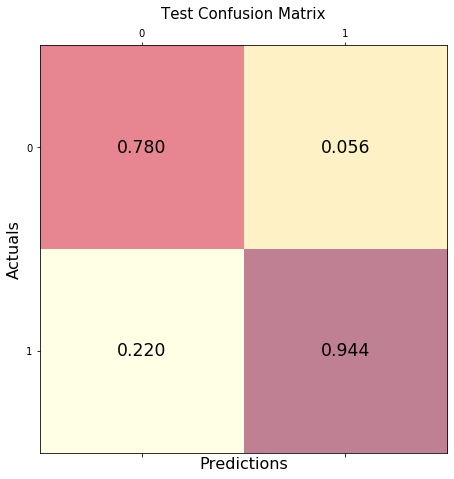

In [65]:
from sklearn import metrics

cmatrix = metrics.confusion_matrix(targets_np, outputs_np, normalize='true')

# Setting the attributes
_, px = plt.subplots(figsize=(7.5, 7.5))
px.matshow(cmatrix, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(cmatrix.shape[0]):
    for n in range(cmatrix.shape[1]):
        px.text(x=m,y=n,s="{:.3f}".format(cmatrix[m, n]), va='center', ha='center', size='xx-large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Test Confusion Matrix', fontsize=15)
plt.show()

In [64]:
tn, fp, fn, tp = cmatrix.ravel()

tn, fp, fn, tp

(0.7804878048780488,
 0.21951219512195122,
 0.05605499735589635,
 0.9439450026441036)